# Problemas de trabajo práctico: Sesiones de doblaje
## Autor
Miguel Ángel Álvarez Cabanes
## Github
https://github.com/maalvarezcabanes/algoritmos_optimizacion

## Importación paquetes y funciones auxiliares

In [1157]:
import numpy as np
import pandas as pd
import random
import os
import logging
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1128]:
def clean_plot(ax, xlabel, ylabel, title, legend = True, rotate = 45):
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if legend:
        ax.legend(bbox_to_anchor=(1.2, 1))
    if rotate:
        ax.tick_params(axis='x', labelrotation = rotate)

## Nota
Voy a usar numpy y pandas para el manejo de los datos con la intención de que la algoritmia quede lo más similar a pseudocódigo sin necesidad de complicar la expresión de las operaciones con listas.

## Variables globales
Aunque no soy demasiado partidario de las variables globales, voy a utilizar algunas para simplificar la lectura del código.

In [1129]:
logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(logging.INFO) # Configuración del nivel de trazas

show_expanded_solution = True # Activación de la impresión de solución expandida

limite_sesiones_actor = 6 # Limite de sesiones por actor y día

## Funciones auxiliares
En esta sección voy a agrupar las funciones auxiliares que voy a usar durante el ejercicio de forma que sea más sencillo (espero) seguir más tarde el proceso de pruebas que he ido realizando.

In [1130]:
def init_problem(problem_file):
    ''' Esta función se utiliza para inicializar los datos del problema y asegurarnos de que siempre partimos de una imagen fresca cada intento de aproximación '''
    df = pd.read_excel(problem_file, skiprows=1).drop(["Unnamed: 11", "Total"], axis=1)
    df.set_index("Toma", inplace=True)
    df.drop("TOTAL", inplace=True)
    df.dropna(inplace=True)
    total_sesiones_por_actor = np.array(df.sum()).astype(np.int32)
    return (df, total_sesiones_por_actor)

In [1131]:
def minimo_coste_hipotetico(df, total_sesiones_por_actor, limite_sesiones_actor):
    ''' Cálculo de un coste mínimo hipotético que se obtendría si se pudiesen asignar los actores a las tomas de forma independiente '''
    coste_minimo_actor = -(total_sesiones_por_actor // -limite_sesiones_actor)
    print(f"Coste mínimo por actor: \n{coste_minimo_actor}")
    coste_minimo = np.sum(coste_minimo_actor)
    print(f"Coste mínimo hipotético: {coste_minimo}")
    return (max(coste_minimo_actor), coste_minimo)

In [1132]:
def analizar_solucion(df, info_dias, limite_sesiones_actor):
    ''' Función que analiza las soluciones mostrando para qué actores estamos pagando más de su coste mínimo hipotético '''
    coste_minimo_actor = -(df.sum() // -limite_sesiones_actor)
    dias_actores = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    uso_actores_solucion = [x[0] for x in info_dias]
    for dias in uso_actores_solucion:
        for i, actor in enumerate(dias):
            if actor:
                dias_actores[i] += 1
    i = 1
    for minimo, uso in zip(coste_minimo_actor, dias_actores):
        if int(minimo) == uso:
            print(f"Hemos logrado el coste mínimo para el actor número {i}. Coste: {uso}")
        else:
            print(f"Para el actor {i} hemos logrado un coste: {uso}. El mínimo hipotético sería {int(minimo)}")
        i += 1

In [1133]:
def imprimir_solucion(df, dias, coste, info_dias, limite_sesiones_actor, show_expanded_solution = False):
    ''' Función auxiliar para mostrar los datos de una solución '''
    if show_expanded_solution:
        i = 1
        for dia, info in zip(dias, info_dias):
            print(f"Dia: {i}")
            print(f"Sesiones: {dia}")
            print(f"Uso actores: {info[0]}")
            print(f"Coste día: {info[1]}\n")
            i += 1
            
    analizar_solucion(df, info_dias, limite_sesiones_actor)                                
    print(f"\nSolucion: {dias}")
    print(f"Coste total: {coste}")

In [1134]:
def coste_dia(df, sesiones):
    ''' Cálculo del coste de un día. En definitiva... número de actores que trabajan ese día '''
    uso_actores = np.array(df.loc[sesiones].sum())
    coste = np.count_nonzero(uso_actores)
    return (uso_actores, coste)

In [1135]:
def coste_total(df, dias):
    ''' Coste total de la solución '''
    coste = 0
    info_dias = []
    for num_dia, dia in enumerate(dias):
        (uso_actores, coste_aux) = coste_dia(df, dia)
        info_dias.append((uso_actores, coste_aux))
        coste += coste_aux
    return (info_dias, coste)

In [1136]:
def coste_sesion_voraz(df, uso_actores_dia, uso_pendiente_actores, nueva_sesion, limite):
    ''' Función usada para establecer el coste de meter una nueva sesión en la programación de un día usando el concepto de que todas las factibles cuestan lo mismo '''
    posible_uso_actores_dia = uso_actores_dia + np.array(df.loc[nueva_sesion])
    logging.debug(f"Posible nueva sesion: {nueva_sesion}.")
    logging.debug(f"Posible uso de actores: {posible_uso_actores_dia}. Max {max(posible_uso_actores_dia)}")
    if max(posible_uso_actores_dia) > limite:
        return None
    else:
        return 0

In [1137]:
def coste_sesion_voraz2(df, uso_actores, uso_pendiente_actores, nueva_sesion, limite):
    ''' Función usada para establecer el coste de meter una nueva sesión en la programación de un día usando el concepto de que tiene menos coste la que permite ir liberando a los actores con menos sesiones '''
    posible_uso_actores = [sum(row) for row in zip(uso_actores, list(df.loc[nueva_sesion]))]
    logging.debug(f"Posible nueva sesion: {nueva_sesion}.")
    logging.debug(f"Posible uso de actores: {posible_uso_actores}. Max {max(posible_uso_actores)}")
    if max(posible_uso_actores) > limite:
        return None
    else:
        return min(uso_pendiente_actores - + np.array(df.loc[nueva_sesion]))

In [1138]:
def mejor_sesion_grasp(df, sesiones_dia, sesiones, uso_pendiente_actores, func_coste_sesion, use_naive, limite, numero_mejores_sesiones):
    ''' Función para seleccionar la siguiente mejor sesión para ser añadida a la programación de un día.
    Si el número_mejores_sesiones es 1 tenemos un algoritmo voraz, si es mayor al número máximo de sesiones será aleatorio. Un valor intermedio regula el grasp '''
    if use_naive:
        if len(sesiones_dia) < limite:
            return sesiones[0]
        else:
            return None
    logging.debug(f"Sesiones dia: {sesiones_dia}.")
    uso_actores_dia = np.array(df.loc[sesiones_dia].sum())
    lista_costes = []
    for j in sesiones:
        coste = func_coste_sesion(df, uso_actores_dia, uso_pendiente_actores, j, limite=limite)
        logging.debug(f"El coste de la sesion {j} es : {coste}.")
        if coste == None:
            continue
        if len(lista_costes) < numero_mejores_sesiones:
            lista_costes.append((coste, j))
        else:
            for i in range(len(lista_costes)):
                if coste < lista_costes[i][0]:
                    lista_costes[i] = (coste, j)
                    break
    if len(lista_costes) == 0:
        return None
    
    return lista_costes[random.randint(0, len(lista_costes) - 1)][1]

In [1139]:
def reordenar_sesiones(sesiones, orden_actores):
    ''' Función auxiliar que permite reordenar las sesiones pendiente en función de un orden específico de actores '''
    sesiones_ordered = []
    for actor in orden_actores:
        for sesion in sesiones:
            if df.loc[sesion][actor]:
                sesiones_ordered.append(sesion)
                sesiones.remove(sesion)
    return sesiones_ordered

In [1140]:
def busqueda_local_actores(df, sesiones, orden_actores, func_coste_sesion, numero_mejores_sesiones = 1):
    ''' Búsqueda local basada en el cambio de orden de los actores '''
    sesiones_copy = sesiones.copy()
    sesiones_reordenadas = reordenar_sesiones(sesiones_copy, orden_actores)
    dias_voraz_ref, (info_dias_voraz_ref, coste_voraz_ref) = algoritmo_basico(df, sesiones_reordenadas, func_coste_sesion, numero_mejores_sesiones=numero_mejores_sesiones)
    for j in range(2):
        for i in range(len(orden_actores)-1-j):
            orden_aux = orden_actores.copy()
            orden_aux[i], orden_aux[i+1+j] = orden_aux[i+1+j], orden_aux[i]
            sesiones_copy = sesiones.copy()
            sesiones_reordenadas = reordenar_sesiones(sesiones_copy, orden_aux)
            dias_voraz_aux, (info_dias_voraz_aux, coste_voraz_aux) = algoritmo_basico(df, sesiones_reordenadas, func_coste_sesion, numero_mejores_sesiones=numero_mejores_sesiones)
            if coste_voraz_aux < coste_voraz_ref:
                logging.debug(f"Nuevo orden de actores: {orden_aux}")
                dias_voraz_ref, (info_dias_voraz_ref, coste_voraz_ref) = dias_voraz_aux, (info_dias_voraz_aux, coste_voraz_aux)
                orden_actores = orden_aux
    return (dias_voraz_ref, (info_dias_voraz_ref, coste_voraz_ref))

In [1141]:
def algoritmo_basico(df, sesiones, func_coste_sesion, numero_mejores_sesiones = 1, use_naive = False, limite = 6):
    ''' Función principal para lanzar una solución sin multiarranque '''
    dias = []
    i = 0
    while len(sesiones):
        dias.append([])
        while True:
            uso_pendiente_actores = np.array(df.loc[sesiones].sum())
            nueva_sesion = mejor_sesion_grasp(df, dias[i], sesiones, uso_pendiente_actores, func_coste_sesion, use_naive=use_naive, limite=limite, numero_mejores_sesiones=numero_mejores_sesiones)
            if nueva_sesion == None:
                i += 1
                break
            dias[i].append(nueva_sesion)
            sesiones.remove(nueva_sesion)
    
    logging.debug(f"Solucion: {dias}")
              
    return (dias, coste_total(df, dias))

In [1142]:
def algoritmo_multiarranque(df, sesiones, intentos, func_coste_sesion, max_dias = 5):
    ''' Función principal para lanzar una solución multiarranque '''
    dias_voras_multi, coste_voraz_multi = dias_naive, coste_naive # :TODO: Chequear si pasarlo como parámetro
    for i in range(intentos):
        sesiones_aux = sesiones.copy()
        random.shuffle(sesiones_aux)
        logging.debug(f"Orden sesiones: {sesiones_aux}")
        dias_aux, (info_aux, coste_aux) = algoritmo_basico(df, sesiones_aux, func_coste_sesion)
        logging.debug(f"Coste voraz: {coste_aux}")
        if coste_aux < coste_voraz_multi:
            dias_voras_multi, (info_voraz_multi, coste_voraz_multi) = dias_aux, (info_aux, coste_aux)
            
    return (dias_voras_multi, (info_voraz_multi, coste_voraz_multi))

## Enunciado
Se precisa coordinar el doblaje de una película. Las reglas de planificación que se deben seguir son:
1. Los actores del doblaje deben coincidir en las tomas en las que sus personajes aparecen juntos en las diferentes tomas.
2. Los actores de doblaje cobran todos la misma cantidad por cada día que deben desplazarse hasta el estudio de grabación independientemente del número de tomas que se graben.
3. No es posible grabar más de 6 tomas por día.
4. El objetivo es planificar las sesiones por día de manera que el gasto por los servicios de los actores de doblaje sea el menor posible.

## Lectura de datos de tomas y actores
Los datos originales están en https://docs.google.com/spreadsheets/d/1Ipn6IrbQP4ax8zOnivdBIw2lN0JISkJG4fXndYd27U0/edit#gid=0, pero los descargo a un fichero "doblaje.xlsx" por comodidad.

A continuación leo los datos con pandas limpiando el DataFrame para solo quedarme con los datos de actores y tomas

In [1143]:
(df, total_sesiones_por_actor) = init_problem(os.path.join(".", "doblaje.xlsx"))
display(df)
print(f"Total sesiones por actor: {total_sesiones_por_actor}")

,1,2,3,4,5,6,7,8,9,10
Toma,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Total sesiones por actor: [22 14 13 15 11  8  3  4  2  2]


## Mínimo coste hipotético
Para establecer un mínimo coste hipotético, voy a sumar las sesiones de cada actor y lo voy a dividir entre seis. Hipotéticamente si los actores pudiesen grabar las sesiones de forma independiente, la suma de esos costes sería el mínimo. Es probable que esa solución no sea factible, pero sabemos seguro que ninguna solución va a ser mejor que esa.

In [1144]:
dias_hipotetico, coste_hipotetico = minimo_coste_hipotetico(df, total_sesiones_por_actor, limite_sesiones_actor)

Coste mínimo por actor: 
[4 3 3 3 2 2 1 1 1 1]
Coste mínimo hipotético: 21


En el mejor de los casos sabemos que no vamos a conseguir un coste menor que 21.

## Planteamiento inicial: Solución naïve
Para la representación de datos voy a crear una lista de días, y cada uno de los días va a estar representado por otra lista de escenas que se ruedan ese día.

La solución naïve consistiría en elegir por orden en grupos de seis tomas por día, por lo que el máximo de días debería ser cinco. Voy a crear esta solución inicial ya que puede ser usada como una referencia de "peor solución".

In [1163]:
begin = time.time_ns()
sesiones = list(df.index)
dias_naive, (info_dias_naive, coste_naive) = algoritmo_basico(df, sesiones, coste_sesion_voraz, use_naive=True)
tiempo_naive = (time.time_ns() - begin) / 1000000
imprimir_solucion(df, dias_naive, coste_naive, info_dias_naive, limite_sesiones_actor, show_expanded_solution = show_expanded_solution)

Dia: 1
Sesiones: [1, 2, 3, 4, 5, 6]
Uso actores: [3. 5. 2. 4. 4. 0. 2. 2. 0. 0.]
Coste día: 7

Dia: 2
Sesiones: [7, 8, 9, 10, 11, 12]
Uso actores: [6. 6. 2. 3. 2. 3. 0. 1. 1. 0.]
Coste día: 8

Dia: 3
Sesiones: [13, 14, 15, 16, 17, 18]
Uso actores: [4. 1. 3. 2. 1. 2. 1. 0. 0. 1.]
Coste día: 8

Dia: 4
Sesiones: [19, 20, 21, 22, 23, 24]
Uso actores: [4. 1. 5. 2. 1. 2. 0. 1. 0. 0.]
Coste día: 7

Dia: 5
Sesiones: [25, 26, 27, 28, 29, 30]
Uso actores: [5. 1. 1. 4. 3. 1. 0. 0. 1. 1.]
Coste día: 8

Para el actor 1 hemos logrado un coste: 5. El mínimo hipotético sería 4
Para el actor 2 hemos logrado un coste: 5. El mínimo hipotético sería 3
Para el actor 3 hemos logrado un coste: 5. El mínimo hipotético sería 3
Para el actor 4 hemos logrado un coste: 5. El mínimo hipotético sería 3
Para el actor 5 hemos logrado un coste: 5. El mínimo hipotético sería 2
Para el actor 6 hemos logrado un coste: 4. El mínimo hipotético sería 2
Para el actor 7 hemos logrado un coste: 2. El mínimo hipotético sería 1


### Conclusiones
Como se puede observar, la solución requiere tres días de rodaje y un coste de 34 unidades.

## Aproximación voraz (I)
En esta aproximación voy a ir asignando las sesiones de forma ordenada escogiendo siempre la primera que "quepa" en el día y relegando a días posteriores las que no.

In [1159]:
begin = time.time_ns()
sesiones = list(df.index)
dias_voraz, (info_dias_voraz, coste_voraz) = algoritmo_basico(df, sesiones, coste_sesion_voraz)
tiempo_voraz = (time.time_ns() - begin) / 1000000
imprimir_solucion(df, dias_voraz, coste_voraz, info_dias_voraz, limite_sesiones_actor, show_expanded_solution = show_expanded_solution)

Dia: 1
Sesiones: [1, 2, 3, 4, 5, 6, 7, 13, 14, 18, 21, 24]
Uso actores: [6. 6. 5. 6. 6. 4. 2. 3. 0. 0.]
Coste día: 8

Dia: 2
Sesiones: [8, 9, 10, 11, 12, 15, 16, 27]
Uso actores: [6. 6. 2. 4. 2. 3. 1. 1. 1. 1.]
Coste día: 10

Dia: 3
Sesiones: [17, 19, 20, 22, 23, 25]
Uso actores: [6. 2. 5. 3. 1. 0. 0. 0. 0. 1.]
Coste día: 6

Dia: 4
Sesiones: [26, 28, 29, 30]
Uso actores: [4. 0. 1. 2. 2. 1. 0. 0. 1. 0.]
Coste día: 6

Hemos logrado el coste mínimo para el actor número 1. Coste: 4
Hemos logrado el coste mínimo para el actor número 2. Coste: 3
Para el actor 3 hemos logrado un coste: 4. El mínimo hipotético sería 3
Para el actor 4 hemos logrado un coste: 4. El mínimo hipotético sería 3
Para el actor 5 hemos logrado un coste: 4. El mínimo hipotético sería 2
Para el actor 6 hemos logrado un coste: 3. El mínimo hipotético sería 2
Para el actor 7 hemos logrado un coste: 2. El mínimo hipotético sería 1
Para el actor 8 hemos logrado un coste: 2. El mínimo hipotético sería 1
Para el actor 9 hemos 

Aunque consigo una solución mejor que la "naïve", en el fondo es fácil observar que en cierta manera pasa algo similar a una aproximación voraz con el problema de la mochila (aunque en este caso minimizando en lugar de maximizando)... es fáci observar que los actores 7, 8, 9, y 10 (que son los que tienen menos carga de trabajo total) han repartido su trabajo en varios días en lugar de concentrarlo.

## Aproximación voraz (II)
Para esta aproximación, voy a usar una nueva función de coste para el algoritmo voraz. Básicamente voy a potenciar la posibilidad de dejar el máximo hueco posible en el día para nuevas sesiones.

In [1160]:
begin = time.time_ns()
sesiones = list(df.index)
dias_voraz2, (info_dias_voraz2, coste_voraz2) = algoritmo_basico(df, sesiones, coste_sesion_voraz2)
tiempo_voraz2 = (time.time_ns() - begin) / 1000000
imprimir_solucion(df, dias_voraz2, coste_voraz2, info_dias_voraz2, limite_sesiones_actor, show_expanded_solution = show_expanded_solution)

Dia: 1
Sesiones: [10, 26, 1, 2, 3, 4, 5, 6, 13, 16, 18, 21, 24]
Uso actores: [6. 6. 5. 6. 6. 4. 2. 3. 2. 1.]
Coste día: 10

Dia: 2
Sesiones: [7, 8, 9, 11, 12, 14, 27]
Uso actores: [6. 5. 3. 4. 3. 3. 0. 1. 0. 0.]
Coste día: 7

Dia: 3
Sesiones: [15, 17, 19, 20, 22, 23]
Uso actores: [6. 2. 5. 2. 1. 0. 1. 0. 0. 0.]
Coste día: 6

Dia: 4
Sesiones: [25, 28, 29, 30]
Uso actores: [4. 1. 0. 3. 1. 1. 0. 0. 0. 1.]
Coste día: 6

Hemos logrado el coste mínimo para el actor número 1. Coste: 4
Para el actor 2 hemos logrado un coste: 4. El mínimo hipotético sería 3
Hemos logrado el coste mínimo para el actor número 3. Coste: 3
Para el actor 4 hemos logrado un coste: 4. El mínimo hipotético sería 3
Para el actor 5 hemos logrado un coste: 4. El mínimo hipotético sería 2
Para el actor 6 hemos logrado un coste: 3. El mínimo hipotético sería 2
Para el actor 7 hemos logrado un coste: 2. El mínimo hipotético sería 1
Para el actor 8 hemos logrado un coste: 2. El mínimo hipotético sería 1
Hemos logrado el coste

## Aproximación voraz con arranque experto
Me pregunto qué pasaría si aplicamos la misma solución, pero ordenando primero las secuencias de forma que las primeras sean las que están los actores menos usados, de forma que tiendan a agruparse sus escenas.

El orden "lógico" sería 10, 9, 7, 8, 6, 5, 3, 4, 2, 1 poniendo por orden inverso de uso de actores, pero usando 10, 9, 8, 7, 6, 5, 4, 3, 2, 1 consigo 26 en lugar de 27.

In [1162]:
begin = time.time_ns()
sesiones = list(df.index)
orden_actores = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
sesiones_reordenadas = reordenar_sesiones(sesiones, orden_actores)
dias_voraz_experto, (info_dias_voraz_experto, coste_voraz_experto) = algoritmo_basico(df, sesiones_reordenadas, coste_sesion_voraz2)
tiempo_voraz_experto = (time.time_ns() - begin) / 1000000
imprimir_solucion(df, dias_voraz_experto, coste_voraz_experto, info_dias_voraz_experto, limite_sesiones_actor, show_expanded_solution = show_expanded_solution)

Dia: 1
Sesiones: [16, 25, 10, 26, 4, 11, 21, 3, 15, 18, 24, 27, 2]
Uso actores: [6. 6. 5. 4. 5. 4. 3. 3. 2. 2.]
Coste día: 10

Dia: 2
Sesiones: [8, 12, 14, 29, 1, 6, 5]
Uso actores: [6. 5. 3. 4. 3. 4. 0. 1. 0. 0.]
Coste día: 7

Dia: 3
Sesiones: [13, 20, 7, 22, 28, 17]
Uso actores: [6. 2. 3. 5. 3. 0. 0. 0. 0. 0.]
Coste día: 5

Dia: 4
Sesiones: [23, 9, 30]
Uso actores: [3. 1. 1. 2. 0. 0. 0. 0. 0. 0.]
Coste día: 4

Hemos logrado el coste mínimo para el actor número 1. Coste: 4
Para el actor 2 hemos logrado un coste: 4. El mínimo hipotético sería 3
Para el actor 3 hemos logrado un coste: 4. El mínimo hipotético sería 3
Para el actor 4 hemos logrado un coste: 4. El mínimo hipotético sería 3
Para el actor 5 hemos logrado un coste: 3. El mínimo hipotético sería 2
Hemos logrado el coste mínimo para el actor número 6. Coste: 2
Hemos logrado el coste mínimo para el actor número 7. Coste: 1
Para el actor 8 hemos logrado un coste: 2. El mínimo hipotético sería 1
Hemos logrado el coste mínimo para 

Creo que la utilización de este punto de partida ha sido muy acertado. Está claro que la forma en la que he implementado la voracidad está muy condicionada por el punto de partida.

## Aproximación voraz multiarranque
Esta aproximación es añternativa a la que he denominado "voraz2", ya que en lugar de ordenar de forma intencionada las sesiones con un determinado criterio, voy a buscar otros puntos de partida utilizando un multiarranque barajando el orden de inicio de las sesiones

In [1164]:
begin = time.time_ns()
sesiones = list(df.index)
dias_voraz_multi, (info_dias_voraz_multi, coste_voraz_multi) = algoritmo_multiarranque(df, sesiones, 100, coste_sesion_voraz2)
tiempo_voraz_multi = (time.time_ns() - begin) / 1000000
imprimir_solucion(df, dias_voraz_multi, coste_voraz_multi, info_dias_voraz_multi, limite_sesiones_actor, show_expanded_solution = show_expanded_solution)

Dia: 1
Sesiones: [10, 26, 8, 2, 14, 21, 28, 13, 16, 3, 27, 18, 24, 5]
Uso actores: [6. 4. 5. 6. 5. 6. 1. 2. 2. 1.]
Coste día: 10

Dia: 2
Sesiones: [30, 9, 20, 1, 29, 12]
Uso actores: [6. 3. 3. 5. 3. 2. 0. 0. 0. 0.]
Coste día: 6

Dia: 3
Sesiones: [19, 4, 11, 15, 6, 7]
Uso actores: [6. 5. 2. 2. 3. 0. 2. 2. 0. 0.]
Coste día: 7

Dia: 4
Sesiones: [22, 25, 23, 17]
Uso actores: [4. 2. 3. 2. 0. 0. 0. 0. 0. 1.]
Coste día: 5

Hemos logrado el coste mínimo para el actor número 1. Coste: 4
Para el actor 2 hemos logrado un coste: 4. El mínimo hipotético sería 3
Para el actor 3 hemos logrado un coste: 4. El mínimo hipotético sería 3
Para el actor 4 hemos logrado un coste: 4. El mínimo hipotético sería 3
Para el actor 5 hemos logrado un coste: 3. El mínimo hipotético sería 2
Hemos logrado el coste mínimo para el actor número 6. Coste: 2
Para el actor 7 hemos logrado un coste: 2. El mínimo hipotético sería 1
Para el actor 8 hemos logrado un coste: 2. El mínimo hipotético sería 1
Hemos logrado el coste

Ni siquiera con un número "alto" de arranques (100) consigo resultados mejores que los de la ordenación inicial dirigida que he llamado "voraz_experto". En el fondo tiene sentido, ya que estoy permutando 30 elementos, por lo que el espacio de posibilidades es 30! La posibilidad de encontrarme con una ordenación inicial interesante es mínima

## Aproximación con búsqueda local de actores
Como he mencionado antes al reordenar las secuencias según el uso de actores, he conseguido mejores resultados con una ordenación que no era exactamente la que habría sido "lógica" usando una ordenación por uso de actores. Sin embargo, curiosamente la que he usado al final podría haberse obtenido como una exploración local de la otra.

Voy a explorar algo más esa idea implementando un algoritmo de búsqueda local en ese sentido. Voy a dejar que se intercambien actores con una o dos posiciones de diferencia con respecto al orden inicial. 

In [1165]:
begin = time.time_ns()
sesiones = list(df.index)
orden_actores = [10, 9, 7, 8, 6, 5, 3, 4, 2, 1]
dias_local, (info_dias_local, coste_local) = busqueda_local_actores(df, sesiones, orden_actores, coste_sesion_voraz2)
tiempo_local = (time.time_ns() - begin) / 1000000
imprimir_solucion(df, dias_local, coste_local, info_dias_local, limite_sesiones_actor, show_expanded_solution = show_expanded_solution)

Dia: 1
Sesiones: [16, 25, 10, 26, 3, 15, 4, 11, 21, 18, 24, 27, 2]
Uso actores: [6. 6. 5. 4. 5. 4. 3. 3. 2. 2.]
Coste día: 10

Dia: 2
Sesiones: [8, 12, 14, 29, 1, 6, 5]
Uso actores: [6. 5. 3. 4. 3. 4. 0. 1. 0. 0.]
Coste día: 7

Dia: 3
Sesiones: [13, 20, 7, 22, 28, 9]
Uso actores: [6. 3. 2. 6. 3. 0. 0. 0. 0. 0.]
Coste día: 5

Dia: 4
Sesiones: [19, 30, 17]
Uso actores: [3. 0. 2. 1. 0. 0. 0. 0. 0. 0.]
Coste día: 3

Hemos logrado el coste mínimo para el actor número 1. Coste: 4
Hemos logrado el coste mínimo para el actor número 2. Coste: 3
Para el actor 3 hemos logrado un coste: 4. El mínimo hipotético sería 3
Para el actor 4 hemos logrado un coste: 4. El mínimo hipotético sería 3
Para el actor 5 hemos logrado un coste: 3. El mínimo hipotético sería 2
Hemos logrado el coste mínimo para el actor número 6. Coste: 2
Hemos logrado el coste mínimo para el actor número 7. Coste: 1
Para el actor 8 hemos logrado un coste: 2. El mínimo hipotético sería 1
Hemos logrado el coste mínimo para el actor 

Con un arranque desde un punto inteligente + algortimo voraz + búsqueda local hemos conseguido mejorar del coste 34 de la solución "naïve" a 25. Sin embargo, seguimos sin llegar al míninimo coste hipotético.

En este punto me planteo tres caminos para seguir:
1. Nueva búsqueda local centrada en los actores para los que no he conseguido el mínimo.
2. Definir una nueva función de voracidad usando una métrica de distancia diferente de la actual (que básicamente con el reordenamiento de sesiones no deja de ser un relleno primero los que tienen menos carga)
3. El mejor algoritmo hasta el momento es determinista. La inclusión de diversificación a la hora de seleccionar el punto de partida no ha ayudado, pero me pregunto si podemos ganar algo aleatorizando un tanto la función de voracidad.

En el siguiente apartado voy a tratar de abordar 2 y 3 al mismo tiempo mediante un grasp.

## GRASP + nueva métrica de distancia + repeticiones

Para la función de distancia voy a potenciar la posibilidad de ir completando las sesiones de los actores, por tanto, para cada sesión voy a considerar como coste el coste residual del actor que se quedaría con menos sesiones pendientes. Para evitar puntos muertos, el coste de una sesión va a ser 1000 si no es factible.

Para el grasp lo que voy a hacer es seleccionar el número de mejores opciones de coste entre las cuales quiero aleatorizar la selección. Dada la componente de aleatoriedad de grasp, voy a realizar el proceso un número de intentos.

In [1175]:
begin = time.time_ns()
sesiones = list(df.index)
orden_actores = [10, 9, 7, 8, 6, 5, 3, 4, 2, 1]
mejor_coste = 200
mejor_dias_local_grasp = None
mejor_info_dias_local_grasp = None
mejor_coste_local_grasp = None
for z in range(2):
    for i in range(1, limite_sesiones_actor):
        dias_local_grasp, (info_dias_local_grasp, coste_local_grasp) = busqueda_local_actores(df, sesiones, orden_actores, coste_sesion_voraz2, numero_mejores_sesiones = i)
        if coste_local_grasp < mejor_coste:
            print(f"Mejor coste con numero_mejores_sesiones: {i}")
            mejor_coste = coste_local_grasp
            mejor_dias_local_grasp, (mejor_info_dias_local_grasp, mejor_coste_local_grasp) = dias_local_grasp, (info_dias_local_grasp, coste_local_grasp)

tiempo_local_grasp = (time.time_ns() - begin) / 1000000
imprimir_solucion(df, mejor_dias_local_grasp, mejor_coste_local_grasp, mejor_info_dias_local_grasp, limite_sesiones_actor, show_expanded_solution = show_expanded_solution)

Mejor coste con numero_mejores_sesiones: 1
Mejor coste con numero_mejores_sesiones: 2
Dia: 1
Sesiones: [10, 26, 25, 3, 16, 4, 11, 15, 21, 24, 18, 2, 27]
Uso actores: [6. 6. 5. 4. 5. 4. 3. 3. 2. 2.]
Coste día: 10

Dia: 2
Sesiones: [12, 14, 8, 29, 1, 6, 5]
Uso actores: [6. 5. 3. 4. 3. 4. 0. 1. 0. 0.]
Coste día: 7

Dia: 3
Sesiones: [20, 13, 22, 9, 28, 7]
Uso actores: [6. 3. 2. 6. 3. 0. 0. 0. 0. 0.]
Coste día: 5

Dia: 4
Sesiones: [17, 23]
Uso actores: [2. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
Coste día: 2

Hemos logrado el coste mínimo para el actor número 1. Coste: 4
Hemos logrado el coste mínimo para el actor número 2. Coste: 3
Para el actor 3 hemos logrado un coste: 4. El mínimo hipotético sería 3
Hemos logrado el coste mínimo para el actor número 4. Coste: 3
Para el actor 5 hemos logrado un coste: 3. El mínimo hipotético sería 2
Hemos logrado el coste mínimo para el actor número 6. Coste: 2
Hemos logrado el coste mínimo para el actor número 7. Coste: 1
Para el actor 8 hemos logrado un coste: 2. 

Con esta aproximación, en ocasiones logro una solución con coste 24 que agrupa la sesiones:
1. [10, 26, 25, 3, 16, 4, 11, 15, 21, 24, 18, 2, 27]
2. [12, 14, 8, 29, 1, 6, 5]
3. [20, 13, 22, 9, 28, 7]
4. [17, 23]

## Conclusiones
1. No sé si he conseguido la solución óptima con un coste de 24, pero la única solución adicional que se me ocurre para ver si podemos acercanos más al mínimo hipotético es actuar de nuevo de forma local pero con una componente que me parece demasiado manual.
2. El "conocimiento" experto y la búsqueda local en la ordenación de actores han permitido realizar las grandes mejoras en el algoritmo con un coste computacional muy bueno.
3. La aleatoriedad del grasp me ha permitido romper la barrera del coste 25, pero a costa de incrementar el tiempo de computación notablemente. (En las siguientes gráficas no se refleja bien el tiempo requerido, ya que he tenido que realizar más intentos de los que ahí se muestran).

In [1176]:
df2 = pd.DataFrame([["hipotetico", dias_hipotetico, coste_hipotetico, 0]], columns = ["Algoritmo", "Numero dias", "Coste", "Tiempo"])
df2.loc[df2.shape[0]] = ["naïve", len(dias_naive), coste_naive, tiempo_naive]
df2.loc[df2.shape[0]] = ["voraz", len(dias_voraz), coste_voraz, tiempo_voraz]
df2.loc[df2.shape[0]] = ["voraz2", len(dias_voraz2), coste_voraz2, tiempo_voraz2]
df2.loc[df2.shape[0]] = ["voraz_experto", len(dias_voraz_experto), coste_voraz_experto, tiempo_voraz_experto]
df2.loc[df2.shape[0]] = ["voraz_multi", len(dias_voraz_multi), coste_voraz_multi, tiempo_voraz_multi]
df2.loc[df2.shape[0]] = ["local_actores", len(dias_local), coste_local, tiempo_local]
df2.loc[df2.shape[0]] = ["local_actores_grasp", len(mejor_dias_local_grasp), mejor_coste_local_grasp, tiempo_local_grasp]
df2

,Algoritmo,Numero dias,Coste,Tiempo
0,hipotetico,4,21,0.0000
1,naïve,5,38,65.3439
2,voraz,4,30,257.9471
3,voraz2,4,29,161.0462
4,voraz_experto,4,26,200.9542
5,voraz_multi,4,28,13355.8868
6,local_actores,4,25,2191.3795
7,local_actores_grasp,4,24,21404.3051


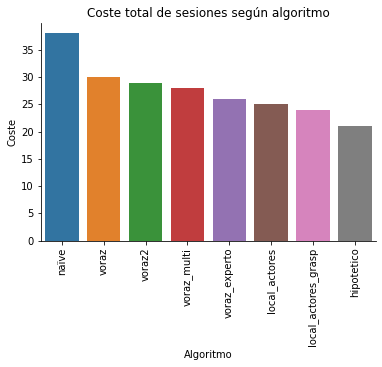

In [1177]:
ax = sns.barplot(data = df2.sort_values(by="Coste", ascending=False), x="Algoritmo", y="Coste")
clean_plot(ax, "Algoritmo", "Coste", "Coste total de sesiones según algoritmo", rotate = 90, legend = False)
plt.show();

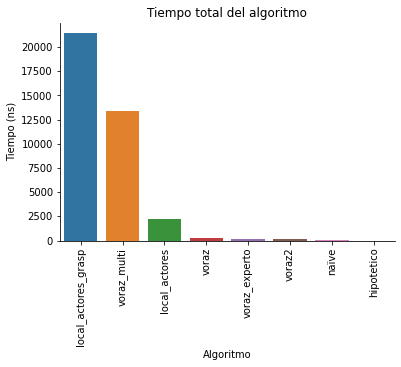

In [1178]:
ax = sns.barplot(data = df2.sort_values(by="Tiempo", ascending=False), x="Algoritmo", y="Tiempo")
clean_plot(ax, "Algoritmo", "Tiempo (ns)", "Tiempo total del algoritmo", rotate = 90, legend = False)
plt.show();